Name: Yifei Sun

Email: sunyifei95@gmail.com

Customer-Order Analysis Report

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.stats import wilcoxon
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [46]:
data = pd.read_csv('/Users/yifeisun/Desktop/screening_exercise_orders_v201810.csv')

A) Assemble a dataframe with one row per customer and the following columns:
    * customer_id
    * gender
    * most_recent_order_date
    * order_count (number of orders placed by this customer)
   Sort the dataframe by customer_id ascending and display the first 10 rows.

In [47]:
# computing most_recent_order_date
most_recent_order = data.groupby(['customer_id','gender'], sort=False)['date'].max()
df_most_recent_order = most_recent_order.to_frame().reset_index()
df_most_recent_order.columns = ['customer_id','gender','most_recent_order_date']

# couting orders placed by the customer
order_count = data['customer_id'].value_counts()
df_order_count = order_count.to_frame().reset_index()
df_order_count.columns = ['customer_id','order_count']

In [48]:
# join to table by customer_id
customer_order = df_most_recent_order.set_index('customer_id').join(df_order_count.set_index('customer_id')).sort_index(by='customer_id',ascending=True)
print(customer_order.head(10))

             gender most_recent_order_date  order_count
customer_id                                            
1000              0    2017-01-01 00:11:31            1
1001              0    2017-01-01 00:29:56            1
1002              1    2017-02-19 21:35:31            3
1003              1    2017-04-26 02:37:20            4
1004              0    2017-01-01 03:11:54            1
1005              1    2017-12-16 01:39:27            2
1006              1    2017-05-09 15:27:20            3
1007              0    2017-01-01 15:59:50            1
1008              0    2017-12-17 05:47:48            3
1009              1    2017-01-01 19:27:17            1


### B) Plot the count of orders per week for the store.

Populating the interactive namespace from numpy and matplotlib


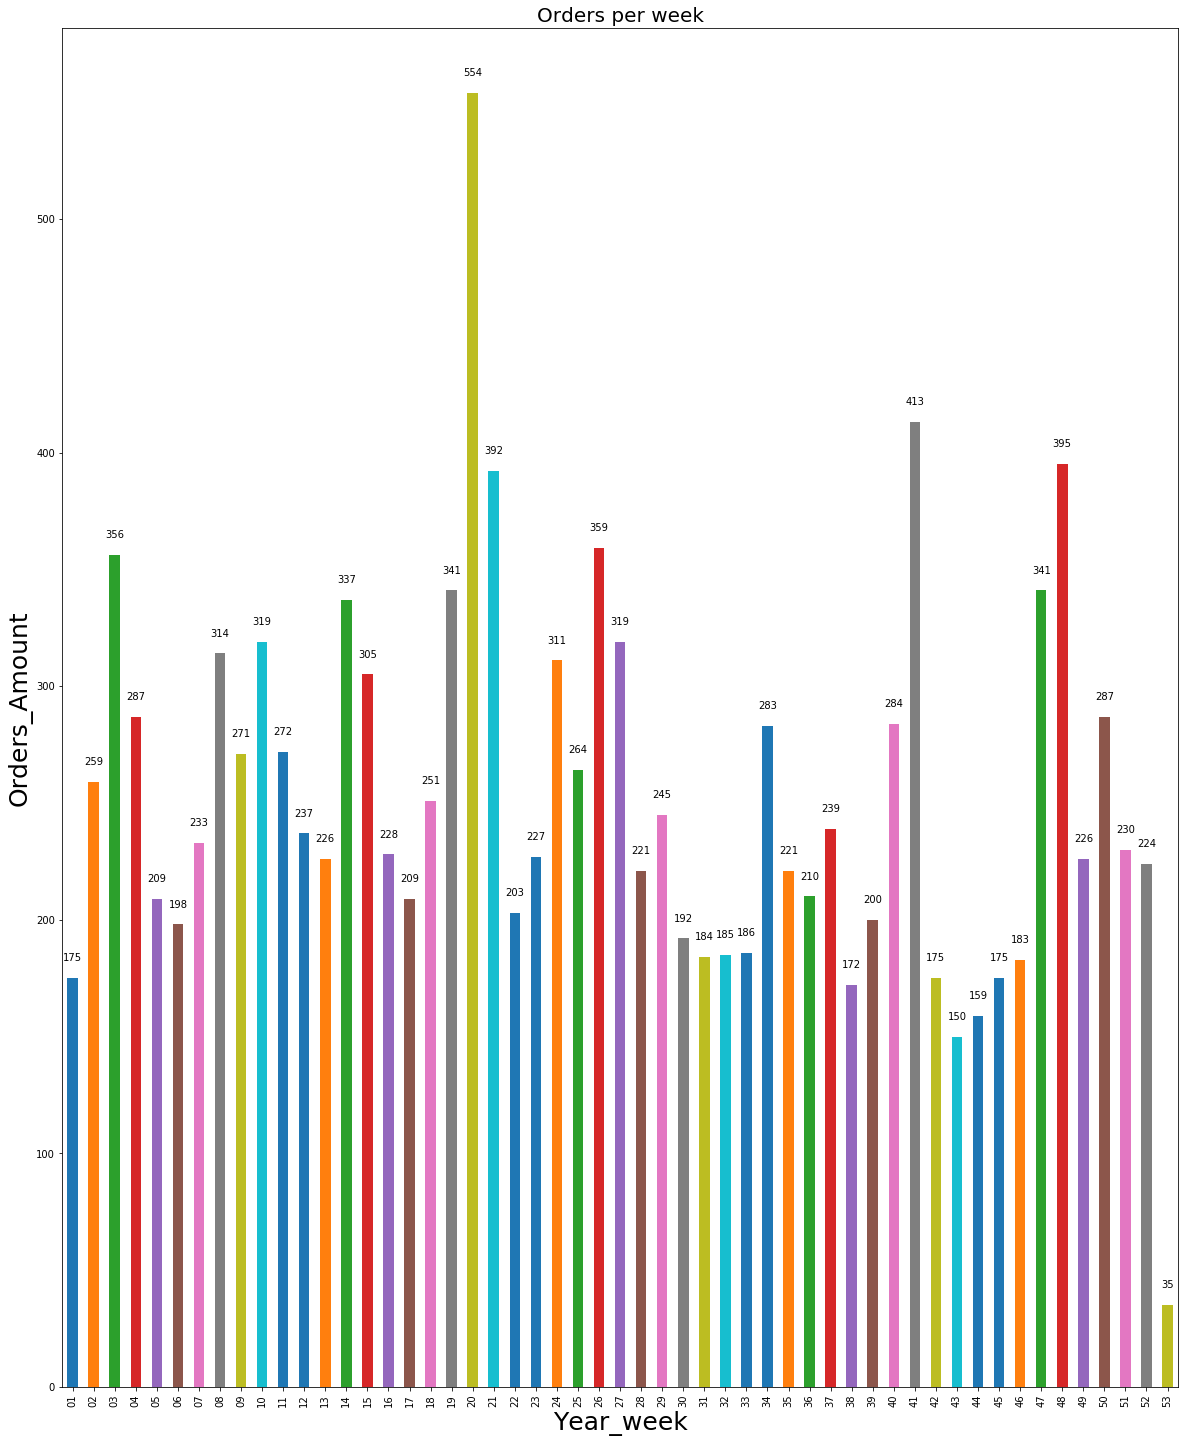

In [49]:

#transform the date to week
data['date'] = pd.to_datetime(data['date'])
data['Week_of_Year'] = data.date.dt.strftime('%U')

# computing and renaming the orders performance per week
Orders_count_week = data.groupby(['Week_of_Year'])['value'].count()
Orders_count_week.columns = ['Week_of_Year','Orders_per_Week']


%pylab inline
pylab.rcParams['figure.figsize'] = (20, 25)
ax = Orders_count_week.plot.bar()
for p in ax.patches: ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 20), textcoords='offset points')  
plt.title('Orders per week',fontsize=20)
plt.ylabel('Orders_Amount',fontsize=25)
plt.xlabel('Year_week',fontsize=25)
plt.show()

### C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?

In [50]:
Gender_Mean = data.groupby(['gender'])['value'].mean()
gender0_mean = data.groupby('gender')['value'].mean()[0]
gender1_mean = data.groupby('gender')['value'].mean()[1]

print(" The mean order value of gender 0 is " + str(round(gender0_mean,4)))
print(" The mean order value of gender 1 is " + str(round(gender1_mean,4)))



 The mean order value of gender 0 is 363.89
 The mean order value of gender 1 is 350.7084


In [51]:
gender0_value = data[data['gender']==0]
gender0_value = gender0_value['value'].to_frame()
gender0_value.columns=['gender0_value']


gender1_value = data[data['gender']==1]
gender1_value = gender1_value['value'].to_frame()
gender1_value.columns=['gender1_value']

In [52]:
print("1.Check for Normality & Variance criteria")
print("(a) Normality")

# Shapiro-Wilk normality test for Gender 0 group 
stat, p = stats.shapiro(gender0_value)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

1.Check for Normality & Variance criteria
(a) Normality
Statistics=0.657, p=0.000
Sample does not look Gaussian (reject H0)


In [53]:
# Shapiro-Wilk normality test for Gender 1 group 
stat, p = stats.shapiro(gender1_value)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.641, p=0.000
Sample does not look Gaussian (reject H0)


In [54]:
print(gender0_value.count())
print(gender1_value.count())
print("Because the N is not equal for two dataset, so we only take part of Gender 0 data")
gender0_value = gender0_value.sample(frac=1)[:6712]
gender0_value_new = gender0_value['gender0_value']
print(gender0_value_new.count()) 

gender0_value    6759
dtype: int64
gender1_value    6712
dtype: int64
Because the N is not equal for two dataset, so we only take part of Gender 0 data
6712


In [55]:
gender1_value_new = gender1_value['gender1_value'].tolist()

In [56]:
print("Because the data is not normality and we don't know the distribution. So I use the nonParametric test")
print("Wilcoxon signed-rank T test")


print("H0: The two sample mean are equal.")
print("H1: The two sample mean are not equal.")

# seed the random number generator
seed(1)
# compare samples
stat, p = wilcoxon(gender0_value_new, gender1_value_new)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Because the data is not normality and we don't know the distribution. So I use the nonParametric test
Wilcoxon signed-rank T test
H0: The two sample mean are equal.
H1: The two sample mean are not equal.
Statistics=10871098.500, p=0.060
Same distribution (fail to reject H0)


#### Based on the Wilcoxon signed-rank T test we can not reject H0, so there is no difference between two sample means. 

### D) Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted gender. What does the confusion matrix tell you about the quality of the predictions?

In [58]:
c_mat = pd.crosstab(data['gender'],data['predicted_gender'],rownames=['True'],colnames=['Predicted'],margins=True)
print('accuracy: ', round(accuracy_score(data['gender'],data['predicted_gender']),4))
print(c_mat)

accuracy:  0.6383
Predicted     0     1    All
True                        
0          3349  3410   6759
1          1463  5249   6712
All        4812  8659  13471


This allows us to see that:

1. The diagonal elements show the number of correct classifications for each class: 3329 and 5249 for the gender classes 0 and 1

2. The off-diagonal elements provide the misclassifications: for example, 3410 of class 0 were misclassified as 1, and 1463 class 1 were misclassified as 0.

3. The total accuracy of the model is 63.83%. However, the confusion matrix shows it performs very different for gender classed 0 and 1. For gender 1, it falsely predicts 21.8% gender classification. However, for gender 0, it incorrectly predicts 50.4% gender classification, means half of the classification result are not accurate.


### E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph.


I want to say one of my favorite tool for doing data visualization is Power BI. It easy to use and combine the SQL query and excel like calculations with various charts which provides an easy way to do the display. For example, during my internship and I was asking to do the customer retention trend. I need to first wrote query to get the new customer in our company each year and show how many times they revisit in the following years. Power BI is a powerful tool to solve this problem quickly and dynamic by writing only two queries. One is the new customer per year query, and another is customer visitation query inside Power BI, then you can generate the chart.  The reason why I choose Power BI to be one of my favorite tools. Sometimes when you solve some fundamental data analysis challenges, tools like Power BI can help you play around with data in a visualize way and sometimes you will get new insight when you play around with data.